In [13]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.filterwarnings("ignore", category=InterpolationWarning)

# 1. Transforming Data
We first transform the data into logarithms to stabilise the variance and to interpret the first difference of the variables as growth rates. Since productivity is observed quarterly, we re-sample the wage and CPIH data to be in quarterly frequency to avoid smoothing bias.

In [14]:
df = pd.read_csv('data/preprocessed/quarterly_data.csv')

# Parsing date and setting index
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date").sort_index()

# Setting as quarter start frequency
df = df.asfreq("QS")

df_log = df.copy()

# Log Transformations
for c in ['CPIH', 'AWE', 'Productivity']:
    if c == 'Productivity':
        df_log['Prod_ln'] = np.log(df_log[c])
    else:
        df_log[f'{c}_ln'] = np.log(df_log[c])

# Creating real wage from wages and productivity
df_log["RealWage_ln"] = df_log["AWE_ln"] - df_log["CPIH_ln"]

display(f"No. of quarterly observations: {df_log.shape[0]}")
display(df_log.head())

'No. of quarterly observations: 101'

,CPIH,AWE,Productivity,CPIH_ln,AWE_ln,Prod_ln,RealWage_ln
Date,,,,,,,
2000-01-01,72.800000,305.320072,82.5,4.287716,5.721361,4.412798,1.433645
2000-04-01,73.466667,310.142558,82.2,4.296832,5.737032,4.409155,1.440200
2000-07-01,73.466667,314.836909,82.7,4.296832,5.752055,4.415220,1.455223
2000-10-01,73.933333,320.155758,82.6,4.303164,5.768808,4.414010,1.465644
2001-01-01,73.700000,324.075836,83.6,4.300003,5.780978,4.426044,1.480975


# 2. Stationarity Tests
We test for stationarity using both the Augmented Dickey-Fuller test and the KPSS test.

## Augmented Dickey Fuller
We test for stationarity firstly on the level variables. We fail to reject the null for the two variables at the 5% level of significance, the series are non-stationary. We then take the first difference of each variable and we reject the null of non-stationarity at even the 1% level of significance. As such the level variables are of order I(1) and the differenced variables are of order I(0).

In [15]:
# Log column list
cols = ['RealWage_ln', 'Prod_ln']

# Running unit root test for each variable
print("Dickey Fuller Test for log variables")
for col in cols:
    adf_test = adfuller(df_log[col], autolag='AIC')[1]
    print(f"{col} : {adf_test}")

#Taking first difference
df_log_diff = df_log[cols].diff().dropna()

#Running unit roots tests for differenced variables
print("\nDickey Fuller Test for log variables - 1st difference")
for col in cols:
    adf_test = adfuller(df_log_diff[col], autolag='AIC')[1]
    print(f"{col} : {adf_test}")

Dickey Fuller Test for log variables
RealWage_ln : 0.13181125796716964
Prod_ln : 0.06482169469104061

Dickey Fuller Test for log variables - 1st difference
RealWage_ln : 1.1752141388911272e-20
Prod_ln : 2.048272406584463e-18


# KPSS test
We test the null of stationarity again, around a constant and around a trend. The KPSS test strongly rejects the null for both trend and level stationarity, strengthening our ADF findings of unit roots.

In [16]:
# Testing for trend stationarity using KPSS
print("\nKPSS Test for log variables (Stationary Around Constant)")
for col in cols:
    stat, p, lags, crit = kpss(df_log[col].dropna(), regression='c', nlags='auto')
    print(f"{col} KPSS statistic : {stat}")
    print(f"{col} p-value: {p}\n")

print("\nKPSS Test for log variables (Stationary Around Trend)")
for col in cols:
    stat, p, lags, crit = kpss(df_log[col].dropna(), regression='ct', nlags='auto')
    print(f"{col} KPSS statistic : {stat}")
    print(f"{col} p-value: {p}\n")


KPSS Test for log variables (Stationary Around Constant)
RealWage_ln KPSS statistic : 1.0953335016730432
RealWage_ln p-value: 0.01

Prod_ln KPSS statistic : 1.573090325199709
Prod_ln p-value: 0.01


KPSS Test for log variables (Stationary Around Trend)
RealWage_ln KPSS statistic : 0.20366945385283494
RealWage_ln p-value: 0.014623954805186896

Prod_ln KPSS statistic : 0.21659265552362014
Prod_ln p-value: 0.01



# 3. Plotting ACF and PACF
Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots were plotted for each first-differenced variable.

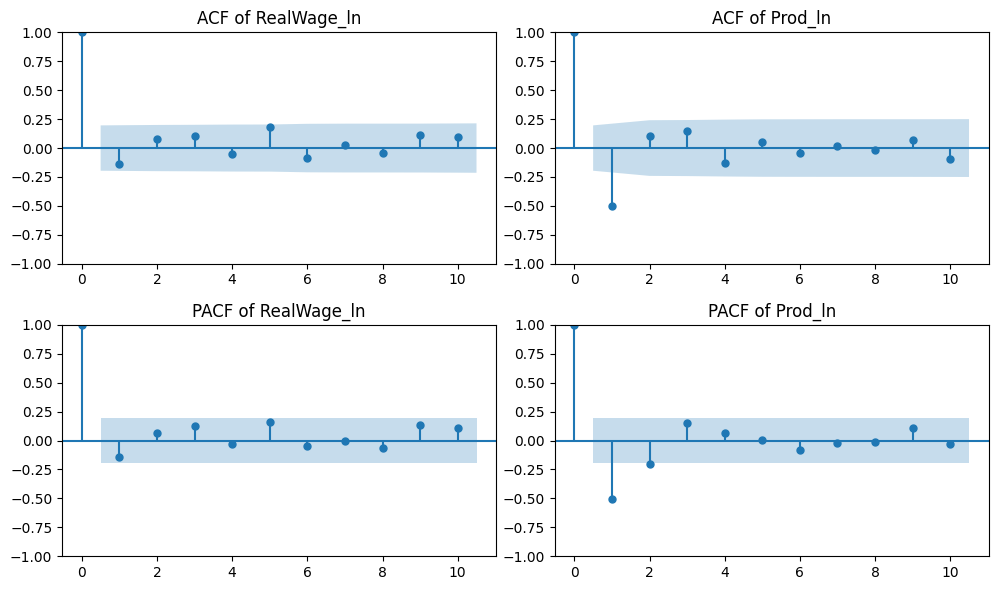

In [17]:
# Setting up plot
fig, axes = plt.subplots(2,2, figsize=(10,6))

for i, col in enumerate(cols):
    # ACF plot with 10 lags - 1st difference
    plot_acf(df_log_diff[col], lags=10, ax=axes[0,i])
    axes[0,i].set_title(f"ACF of {col}")

    # PACF plot with 10 lags
    plot_pacf(df_log_diff[col], lags=10, method="ywm", ax=axes[1,i])
    axes[1,i].set_title(f"PACF of {col}")

plt.tight_layout()
plt.show()


# Interpretation
The plots suggest that there is limited short-run autocorrelation, with significance concentrated at the first lag. This supports a selection of a low lag specification.

# 4. Lag Order Selection


In [18]:
# Copying df
joh_data = df_log[cols]

# Specifying VAR model
var_model = VAR(joh_data)

# We select lags going up to 2 years
lag_sel = var_model.select_order(maxlags=8)

print(lag_sel.summary())

# Lags selected by AIC and BIC
l_aic = lag_sel.aic
l_bic = lag_sel.bic
print("Selected lag orders:")
print("AIC: ",l_aic)
print("BIC: ",l_bic)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -13.95      -13.90   8.708e-07      -13.93
1      -18.05      -17.89   1.446e-08      -17.99
2     -18.40*     -18.13*  1.021e-08*     -18.29*
3      -18.39      -18.00   1.037e-08      -18.23
4      -18.34      -17.85   1.081e-08      -18.15
5      -18.26      -17.66   1.175e-08      -18.02
6      -18.23      -17.52   1.216e-08      -17.94
7      -18.21      -17.39   1.242e-08      -17.88
8      -18.13      -17.21   1.343e-08      -17.76
-------------------------------------------------
Selected lag orders:
AIC:  2
BIC:  2


# 5. Cointegration Test
Now that all the variables are stationary of order I(1) we construct a candidate lag set to test for cointegration, a long-term equilibrium relationship between two or more variables. We test using the Johansen trace test with lag order of:
 + $l=2$ - Chosen by AIC and BIC
 + $l=8$ - Candidate higher lag specification

We then compare the trace statistic to the critical values at 1%, 5% and 10% confidence intervals to determine the rank of cointegration. Specifications including both intercepts and trend were tested (Deterministic order: [0,1]).

In [19]:
# Creating list of lag orders -- includes l=12 for
lags = [int(l_aic), 8]

# Converting lag orders to Johansen k_ar_diff
joh_lags = []

for lag in lags:
    joh_lags.append(lag - 1)

print("Candidate lags: ", sorted(joh_lags))

# Running test and iterating over deterministic terms and lag candidates

# det = 0 -> constant   det = 1 -> linear trend
for det in [0,1]:
    print('\nDETERMINISTIC ORDER =', det)
    for lag in sorted(joh_lags):
        joh = coint_johansen(joh_data, det_order=det, k_ar_diff=lag)
        print(f"\nLags: {lag}")
        for r in range(len(cols)):

            # Johansen test trace statistic
            trace = joh.lr1[r]

            cv10  = joh.cvt[r, 0]   # 10% critical value
            cv5   = joh.cvt[r, 1]   # 5% critical value
            cv1   = joh.cvt[r, 2]   # 1% critical value

            rej10 = "Reject" if trace > cv10 else "Fail"
            rej5 = "Reject" if trace > cv5 else "Fail"
            rej1 = "Reject" if trace > cv1 else "Fail"

            display(
                f"H0: r <= {r} | trace = {trace:.3f} | "
                f"cv10 = {cv10:.3f} -> {rej10} | "
                f"cv5  = {cv5: .3f} -> {rej5} | "
                f"cv1  = {cv1: .3f} -> {rej1} | "
            )


Candidate lags:  [1, 7]

DETERMINISTIC ORDER = 0

Lags: 1


'H0: r <= 0 | trace = 11.696 | cv10 = 13.429 -> Fail | cv5  =  15.494 -> Fail | cv1  =  19.935 -> Fail | '

'H0: r <= 1 | trace = 3.938 | cv10 = 2.705 -> Reject | cv5  =  3.841 -> Reject | cv1  =  6.635 -> Fail | '


Lags: 7


'H0: r <= 0 | trace = 9.677 | cv10 = 13.429 -> Fail | cv5  =  15.494 -> Fail | cv1  =  19.935 -> Fail | '

'H0: r <= 1 | trace = 2.772 | cv10 = 2.705 -> Reject | cv5  =  3.841 -> Fail | cv1  =  6.635 -> Fail | '


DETERMINISTIC ORDER = 1

Lags: 1


'H0: r <= 0 | trace = 15.240 | cv10 = 16.162 -> Fail | cv5  =  18.398 -> Fail | cv1  =  23.148 -> Fail | '

'H0: r <= 1 | trace = 4.262 | cv10 = 2.705 -> Reject | cv5  =  3.841 -> Reject | cv1  =  6.635 -> Fail | '


Lags: 7


'H0: r <= 0 | trace = 11.376 | cv10 = 16.162 -> Fail | cv5  =  18.398 -> Fail | cv1  =  23.148 -> Fail | '

'H0: r <= 1 | trace = 2.676 | cv10 = 2.705 -> Fail | cv5  =  3.841 -> Fail | cv1  =  6.635 -> Fail | '

# Interpretation
With two variables we are only interested in the null hypothesis: $$ \text{H0}: r \le 0 $$
If we reject the null then it means there is evidence of a cointegrating relationship.
| Deterministic Term | Lag | r ≤ 0 (10%) | r ≤ 0 (5%) | r ≤ 0 (1%) |
| ------------------ | --- | ----------- | ---------- | ---------- |
| Constant (det=0)   | 1   | Fail        | Fail       | Fail       |
| Constant (det=0)   | 7  | Reject      | Fail     | Fail       |
| Trend (det=1)      | 1   | Fail        | Fail       | Fail       |
| Trend (det=1)      | 7  | Fail        | Fail       | Fail       |

With a one lag we fail to reject the null at all specifications and all confidence intervals, there is no evidence of cointegration. With a higher lag specification, we only reject the null at the 10% level, in the specification without a trend. There is very weak evidence of cointegration.

# Implications for Model Selection
With both a low lag specification and a high lag specification we fail to reject $r \leq 0$ at all levels of significance. As such we fail to reject the null hypothesis of no cointegration, there is no long-term cointegrating relationship between our variables. Since our variables are I(1) and cointegration is not supported at conventional levels of significance, we will prefer a **VAR in first differences model** over a VECM.

# 6. Model Specification and First Estimate
We will now take the differenced data and select the appropriate lag order to run a VAR(p) model. We calculate the information criteria and both AIC and BIC criteria choose **1 lag**. As such we fit a VAR(1) model. We are estimating:

## Real Wage Growth Equation
$$ \begin{align}
\Delta RW_t &= \alpha_0
+ \alpha_1 \Delta RW_{t-1}
+ \beta_1 \Delta Prod_{t-1}
+ \varepsilon_{1t}
\end{align} $$

## Productivity Growth Equation
\begin{align}
\Delta Prod_t &= \gamma_0
+ \gamma_1 \Delta RW_{t-1}
+ \delta_1 \Delta Prod_{t-1}
+ \varepsilon_{2t}
\end{align}



In [20]:
# Copying differenced data
var_data = df_log_diff

# Selecting lag length
lag_sel_diff = VAR(var_data).select_order(12)
print(lag_sel_diff.summary())

# Selecting parsimonious BIC specification - 2 lags
p_opt = lag_sel_diff.bic

# Fitting VAR
var_model = VAR(var_data).fit(p_opt)
print(var_model.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -17.91      -17.85   1.670e-08      -17.89
1      -18.30*     -18.13*  1.125e-08*     -18.23*
2       -18.27      -17.99   1.161e-08      -18.16
3       -18.22      -17.82   1.224e-08      -18.06
4       -18.13      -17.63   1.337e-08      -17.93
5       -18.09      -17.47   1.395e-08      -17.84
6       -18.07      -17.34   1.425e-08      -17.78
7       -17.99      -17.15   1.548e-08      -17.65
8       -17.94      -16.98   1.640e-08      -17.55
9       -17.87      -16.80   1.759e-08      -17.44
10      -17.81      -16.63   1.873e-08      -17.34
11      -17.79      -16.49   1.931e-08      -17.27
12      -17.71      -16.30   2.111e-08      -17.14
--------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 25, Feb

# VAR Summary Interpretation

## Real Wage Growth Equation
| Variable    | Coefficient |
|-------------|-------------|
| L1.RealWage | -0.183 (*)  |
| L1.Prod_ln  | 0.196 (**)  |

The coefficient on real wage's own lag is negative, and we can only reject the null at the 10% level of significance. There is marginal evidence of mean reversion in wage growth.

The coefficient on lagged productivity is significant at the 5% level and can be interpreted as a 1% increase in productivity growth last quarter leading to a 0.196% increase in real wage growth. The conclusion from this is that productivity growth translates to much smaller relative real wage growth, consistent with what we observed during out exploratory analysis.

## Productivity Growth Equation
| Variable    | Coefficient  |
|-------------|--------------|
| L1.RealWage | -0.084       |
| L1.Prod_ln  | -0.489 (***) |

The coefficient on the wage term is not significant at even the 10% level, and we can conclude that there is weak evidence of wage growth leading to productivity growth. The causality chain points towards productivity growth -> wage growth.

The coefficient on productivity's own lag is highly significant and signals towards strong mean reversion. A productivity shock in t-1 rapidly adjusts in t, so any shock dissipates quickly.

# 7. Residual Diagnostics
We will test the model for residual autocorrelation, stability and normality.

In [21]:
print("-------- Portmanteau Test --------")
print(var_model.test_whiteness(nlags=12), "\n")

print("-------- Stability Test --------")
print("Stable:", var_model.is_stable())
print(var_model.roots, '\n')

print("-------- Normality Test --------")
print(var_model.test_normality())


-------- Portmanteau Test --------
<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 12 is zero: fail to reject at 5% significance level. Test statistic: 30.857, critical value: 60.481>, p-value: 0.933> 

-------- Stability Test --------
Stable: True
[-3.95985159 -2.37980985] 

-------- Normality Test --------
<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 223.489, critical value: 9.488>, p-value: 0.000>


# Diagnostics Interpretation
## Portmanteau Test (Residual Autocorrelation)
$ H_0 : \text{No residual autocorrelation up to 12 lags} $

Our p-value is 0.933 so we strongly fail to reject the null, there is no serial correlation in the residuals.

## Stability Test
The test concludes that the model is stable, all inverse roots are inside unit circle.

## Normality Test
$ \text{p-value} = 0.000 $

We strongly reject the null of normally distributed residuals; our residuals are not normally distributed. This is expected and likely the case of structural breaks e.g. COVID crisis.

# 9. Granger Causality

In [22]:
# Productivity Granger Causes Real Wage test
gc_prod_to_rw = var_model.test_causality(
    caused='RealWage_ln',
    causing='Prod_ln',
    kind='f'
)

print(gc_prod_to_rw.summary(), '\n')


# Real Wage Granger Causes Productivity test
gc_rw_to_prod = var_model.test_causality(
    caused='Prod_ln',
    causing='RealWage_ln',
    kind='f'
)

print(gc_rw_to_prod.summary())

Granger causality F-test. H_0: Prod_ln does not Granger-cause RealWage_ln. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value         df        
--------------------------------------------------------
         5.204          3.890   0.024 (1, np.int64(192))
-------------------------------------------------------- 

Granger causality F-test. H_0: RealWage_ln does not Granger-cause Prod_ln. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value         df        
--------------------------------------------------------
        0.6372          3.890   0.426 (1, np.int64(192))
--------------------------------------------------------


### First Test
\begin{align*}
H_0 &: \text{Prod\_ln} \text{ does not Granger-cause } \text{RealWage\_ln}$ \\
F &= 5.204, \quad p = 0.024
\end{align*}

We reject the null at 5% level of significance; there is strong evidence that **productivity growth Granger causes real wage growth.**


### Second Test
\begin{align*}
H_0 &: \text{RealWage\_ln} \text{ does not Granger-cause } \text{Prod\_ln} \\
F &= 0.6372, \quad p = 0.426
\end{align*}


We fail to reject the null at even the 10% level, there is no evidence that real wage growth Granger causes productivity growth.

### Conclusion
There is strong evidence suggesting the Granger causality chain is:

$ \text{Prod\_ln} \longrightarrow \text{RealWage\_ln} $

Productivity growth **precedes** real wage growth, wage growth responds to productivity shocks. There is no evidence of the opposite case.


# 10. Impulse Response Functions
Based on our Granger-Causality tests we need to re-order our variables so that the Cholesky IRFs capture the right chain of causality: Productivity Growth --> RealWage Growth

Index(['RealWage_ln', 'Prod_ln'], dtype='object')


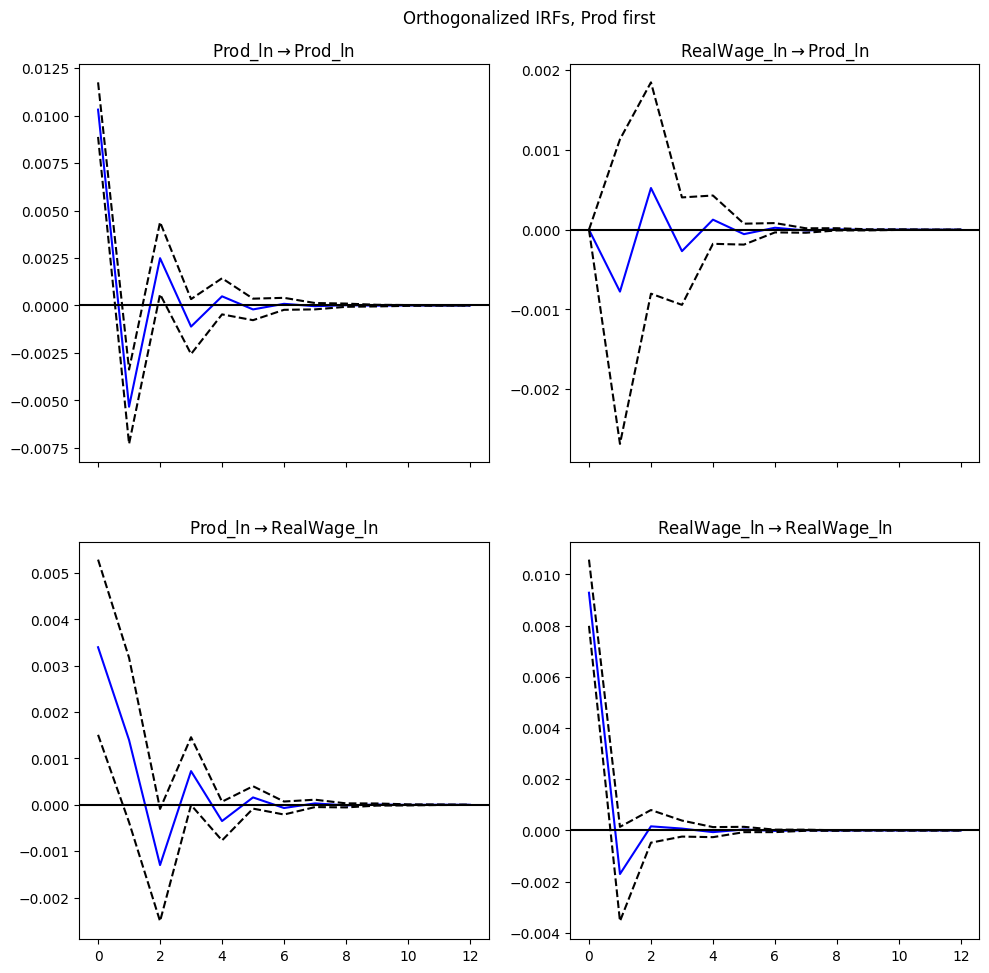

In [23]:
# Displaying ordering of columns
print(var_data.columns)

# Rearranging columns
var_data_ord = var_data[['Prod_ln', 'RealWage_ln']]

# Optimal BIC lags
var_final = VAR(var_data_ord).fit(p_opt)

# Compute IRFs
horizon = 12    # 3 years in quarters
irf = var_final.irf(horizon)

# Plotting Cholesky orthogonalized IRFs
irf.plot(orth=True)
plt.suptitle(f"Orthogonalized IRFs, Prod first")
plt.show()

# Interpretation
## Prod_ln -> Prod_ln
This is the impulse response of productivity growth on its own shock. There is a large immediate positive response at period 0, with a rapid correction in the next period. It then converges to zero quickly, 5-6 periods later. The interpretation is that **productivity shocks** are temporary and mean reverting.

## RealWage_ln -> Prod_ln
This is the effect of a wage growth shock on productivity growth. There is a small negative response in the first period and the effect quickly disappears. The confidence bands are very wide and signal towards the effect not being stat. significant. **Wage shocks do not have a significant effect on productivity growth**.

## Prod_ln -> RealWage_ln
*This is the most important IRF as we established that productivity growth Granger causes wage growth.* We see an immediate positive wage response which stabilises quickly. We can also see that the confidence bands cross zero after the initial shock, which is evidence of a short-run effect which dissipates quickly. **A positive productivity growth shock increases real wage growth, but only in the short-run.**

## RealWage_ln -> RealWage_ln
This is real wage's impulse response to its own shock. It has a strong response to the initial shock and rapidly dissipates. We see again that there is rapid mean reverting behaviour, any shock only lasts for a period or 2.

## Conclusion
The IRF plots confirm our findings of productivity growth Granger causing real wage growth but not the other way around. We conclude from them that **a productivity growth shock leads to a strong positive response from wage growth in the short-run, which quickly decays.**


# 11. FEVD (Forecast Error Variance Decomposition)

FEVD for Prod_ln
       Prod_ln  RealWage_ln
0     1.000000     0.000000
1     0.995549     0.004451
2     0.993830     0.006170
3     0.993381     0.006619
4     0.993283     0.006717
5     0.993263     0.006737
6     0.993260     0.006740
7     0.993259     0.006741
8     0.993259     0.006741
9     0.993259     0.006741
10    0.993259     0.006741
11    0.993259     0.006741

FEVD for RealWage_ln
       Prod_ln  RealWage_ln
0     0.118118     0.881882
1     0.131543     0.868457
2     0.145582     0.854418
3     0.149874     0.850126
4     0.150864     0.849136
5     0.151066     0.848934
6     0.151105     0.848895
7     0.151112     0.848888
8     0.151114     0.848886
9     0.151114     0.848886
10    0.151114     0.848886
11    0.151114     0.848886


None


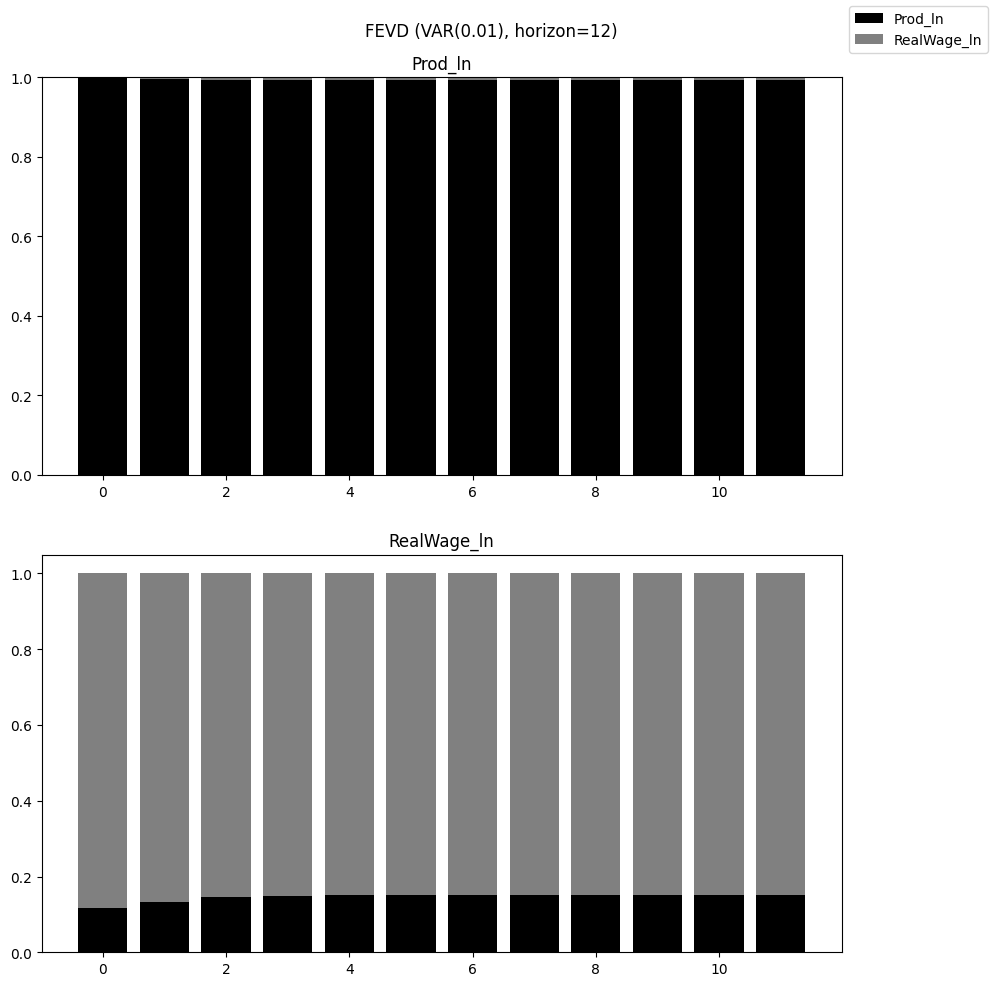

In [24]:
h = 12  # 3 years
fevd = var_final.fevd(h)

print(fevd.summary())

# Plotting FEVD
fevd.plot()
plt.suptitle(f"FEVD (VAR({p}), horizon={h})")
plt.show()

# FEVD Interpretation
We are here measuring the variance of the forecast error i.e. what proportion of an unexpected fluctuation in a variable is caused by a certain variable's shock.

## Prod_ln Variance Decomposition
We see that for productivity growth, at all periods, its shocks alone account for close to 100% of its forecast uncertainty. As such we conclude that productivity growth fluctuations are almost entirely the result of productivity shocks.

## RealWage_ln Variance Decomposition
At period t=0 wage growth shocks explain 85-90% of real wage growth's forecast uncertainty, with productivity growth shocks accounting for around 15%. In the following periods the share of productivity growth shocks increases but only slightly, with wage shocks still explaining the majority of the real wage forecast error.

## Big Picture
We can conclude that productivity growth fluctuations are largely independent of wage shocks while real wage growth fluctuations are **partly explained** by productivity shocks. This is in line with our Granger causality tests and the IRF plots.

# Conclusion
The results suggest a productivity-led real wage growth channel, where real wage gains are primarily driven by short-run productivity shocks rather than a long-run cointegrating relationship. We also provided strong evidence for the Granger causality chain being unidirectional, with productivity growth preceding real wage growth. Lastly, we discovered that productivity growth fluctuations are largely independent of real wage shocks.